In [1]:
%load_ext autoreload
%autoreload 2

import RS_utils
import RS_dataset
import RS_models

import numpy as np 
from glob import glob
import os
import torch
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader

In [2]:
#-- data
img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"

img_path_ship  = np.array(sorted(glob(os.path.join(img_path, "*.png"))) )
mask_path_ship = np.array(sorted(glob(os.path.join(mask_path, "*.png"))) )

aa = np.load("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/03.data_list/512_ships.npy")

selected_paths_img = img_path_ship[aa]
selected_paths_mask  = mask_path_ship[aa]

In [3]:
#-- args
EXEC_VER = 24 
BATCH_SIZE = 4
DEVICE = "cuda:0"
DEVICES = [0,1,2,3]
RESUME = False
SAVE_EPOCH = 20

In [4]:
#-- category 
ISAID_CLASSES_SHIP = (
    'background','ship','harbor' 
    )
ISAID_PALETTE_SHIP = {
    0: (0, 0, 0), 
    1: (0, 0, 63), 
    2: (0, 100, 155)}


train_dataset = RS_dataset.Seg_RS_dataset_edge_v1(img_dir=selected_paths_img, mask_dir=selected_paths_mask, image_resize = None, phase="train",palette=ISAID_PALETTE_SHIP,gaussian=True,mask_onehot=True,softmax=True )
dataloader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn)

In [5]:
label, label_edge  = train_dataset.__getitem__(15)

In [6]:
label.shape

torch.Size([3, 256, 256])

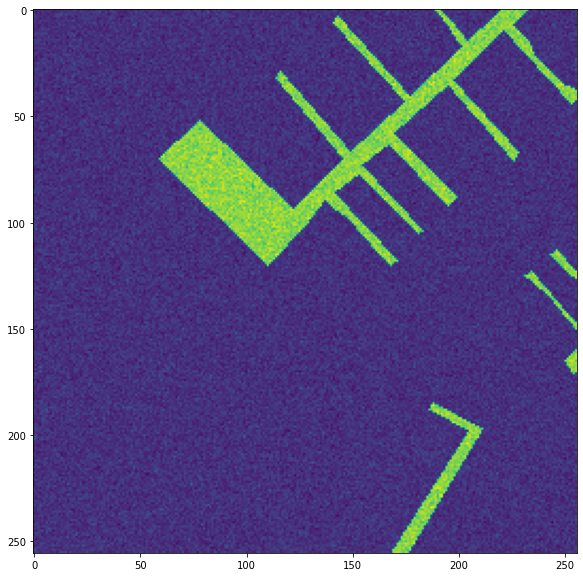

In [7]:
RS_utils.torch_display_mask( label[2,:,:] )

In [8]:
# label_edge.shape

In [19]:
model = RS_models.Edge_Net(input_channel=3)

In [20]:
out_ = model(label)

In [21]:
import torch.nn as nn 
criterion = nn.BCELoss()

In [22]:
label_edge = label_edge.float()

In [23]:
label_edge.shape

torch.Size([1, 256, 256])

In [24]:
out_.shape

torch.Size([1, 256, 256])

In [25]:
out_sig = torch.sigmoid(out_)

In [16]:
criterion(out_sig, label_edge)

tensor(0.7071, grad_fn=<BinaryCrossEntropyBackward0>)

In [17]:
out_sig

tensor([[[0.5026, 0.5048, 0.5066,  ..., 0.5095, 0.5102, 0.5085],
         [0.5081, 0.5117, 0.5126,  ..., 0.5183, 0.5154, 0.5092],
         [0.5130, 0.5127, 0.5132,  ..., 0.5179, 0.5155, 0.5081],
         ...,
         [0.5125, 0.5103, 0.5097,  ..., 0.5089, 0.5067, 0.5065],
         [0.5141, 0.5131, 0.5095,  ..., 0.5106, 0.5069, 0.5060],
         [0.5160, 0.5107, 0.5103,  ..., 0.5116, 0.5048, 0.5056]]],
       grad_fn=<SigmoidBackward0>)

In [18]:
#---
import torch.nn as nn 

model = RS_models.Edge_Net()
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="mean") 
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
#---

epochs = 999
for epoch in range(epochs):
    
    iteration = 0
    epoch_running_loss = 0 
    
    #tqdm_iterator = tqdm(data_loader["train"], desc=f"Epoch {epoch}")
    
    for index, data in enumerate(dataloader):
        
        masks, masks_edge = data
    
        #---
        masks, masks_edge = masks.to(DEVICE), masks_edge.float().to(DEVICE)
        
        
        # opt
        optimizer.zero_grad()
        
        # runs
        outputs = model(masks)
        
        # criterion
        outputs = outputs.squeeze(1)
        masks_edge = masks_edge.squeeze(1)

        # loss
        loss = criterion(outputs, masks_edge)
        loss.backward()
        #fabric.backward(loss)
        optimizer.step()
        
        # stat
        epoch_running_loss += loss.item()

        # log
        #logger.info(f"epoch : {epoch} iter : {index} loss: {loss:.5f} dice: {dice_score:.5f}" )
        log = {'loss': f'{loss / 10:.5f}' }
        print(log)
        #wandb.log(log)

        log_iter = 100
        
        if (index % log_iter) == 0:    # print every 2000 mini-batches
            print(f"epoch : {epoch} , iter : {index} , total_iter : {len(dataloader)} , running_loss : {epoch_running_loss / (index +1)}")
        
    
    #-- save 
    
    if epoch % SAVE_EPOCH ==0:
        #-- save 
        save_path = f"./02.ckpts/ver_{EXEC_VER}_epoch_{epoch + 1}.pt"
        torch.save(model.state_dict(), save_path)

TypeError: __init__() missing 1 required positional argument: 'input_channel'